In [155]:
import pandas as pd
import os
from dotenv import load_dotenv
import requests
from bs4 import BeautifulSoup
import wradlib as wrl
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LinearSegmentedColormap, LogNorm
import geopandas as gpd
from shapely.ops import transform
from pyproj import Transformer

In [156]:
load_dotenv()
PROJECT_PATH = os.getenv("project_path")
PROJECT_PATH = os.path.normpath(PROJECT_PATH)
TEMP_DIR = os.path.join(PROJECT_PATH, "temp")
DATA_DIR = os.path.join(PROJECT_PATH, "data")

WWW_PATH  = os.getenv('www_path')
WWW_PATH = os.path.normpath(WWW_PATH)

os.environ["WRADLIB_DATA"] = TEMP_DIR

In [157]:
def get_files_sri():
    url = 'https://danepubliczne.imgw.pl/pl/datastore/getFilesList'

    headers = {
        'Accept': '*/*',
        'Accept-Language': 'en-US,en;q=0.9',
        'Connection': 'keep-alive',
        'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
        'Origin': 'https://danepubliczne.imgw.pl',
        'Referer': 'https://danepubliczne.imgw.pl/pl/datastore?product=COMPO_SRI.comp.sri',
        'Sec-Fetch-Dest': 'empty',
        'Sec-Fetch-Mode': 'cors',
        'Sec-Fetch-Site': 'same-origin',
        'Sec-GPC': '1',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36',
        'X-Requested-With': 'XMLHttpRequest',
        'sec-ch-ua': '"Brave";v="137", "Chromium";v="137", "Not/A)Brand";v="24"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
    }

    cookies = {
        'ci_session': 'vstqm20aulpqntb3pmnb2925qq0t1k8e',  # replace with fresh session if needed
    }

    data = {
        'productType': 'oper',
        'path': '/Oper/Polrad/Produkty/POLCOMP/COMPO_SRI.comp.sri',
    }

    response = requests.post(url, headers=headers, cookies=cookies, data=data)

    # Parse the response using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract all hrefs from <a> tags
    all_links = [
        "https://danepubliczne.imgw.pl/" + a['href']
        for a in soup.find_all('a', href=True)
    ]

    return all_links

def download_file(url, dir_path):
    """
    Download a file from the given URL into the specified directory.

    Parameters:
    - url (str): The full URL of the file to download.
    - dir_path (str): Local directory to save the file into.
    """
    # Ensure directory exists
    os.makedirs(dir_path, exist_ok=True)

    # Extract the filename from the URL
    filename = url.split('/')[-1]

    # Full local path
    file_path = os.path.join(dir_path, filename)

    try:
        # Stream download for large files
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(file_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
        print(f"Downloaded: {filename}")
        return file_path
    except requests.RequestException as e:
        print(f"Failed to download {url}: {e}")
        return None

def remove_all_files_from_dir(dir_path):
    """
    Remove all files from the specified directory.

    Parameters:
    - dir_path (str): Path to the directory to clear.
    """
    if not os.path.exists(dir_path):
        print(f"Directory does not exist: {dir_path}")
        return

    removed_files = 0
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        if os.path.isfile(file_path):
            try:
                os.remove(file_path)
                removed_files += 1
            except Exception as e:
                print(f"Failed to remove {file_path}: {e}")

    print(f"Removed {removed_files} files from {dir_path}")

In [158]:
urls = get_files_sri()
urls = [f for f in urls if f.endswith('sri')]

In [159]:
url = urls[-1]
file_path = download_file(url,TEMP_DIR)

Downloaded: 2025061620100000dBR.sri


In [160]:
filename = wrl.util.get_wradlib_data_file(file_path)
rbdict   = wrl.io.read_rainbow(filename)

In [161]:
min_val = float(rbdict['product']['data']['radarpicture']['@min'])
max_val = float(rbdict['product']['data']['radarpicture']['@max'])
depth = int(rbdict['product']['data']['radarpicture']['datamap']['@depth'])
proj4string = rbdict['product']['data']['radarpicture']['projection']['proj4string']

lat_lr = rbdict['product']['data']['radarpicture']['projection']['@lat_lr']
lat_ul = rbdict['product']['data']['radarpicture']['projection']['@lat_ul']
lon_lr = rbdict['product']['data']['radarpicture']['projection']['@lon_lr']
lon_ul =  rbdict['product']['data']['radarpicture']['projection']['@lon_ul']

raw_values = np.array(rbdict['product']['data']['radarpicture']['datamap']['data'])

# correct scaling
scale = np.power(2, depth) - 1
values_db = (raw_values / scale) * (max_val - min_val) + min_val
values = 10 ** (values_db / 10)


In [162]:
datetime_str = rbdict['product']['data']['@date']+' '+rbdict['product']['data']['@time']

Original CRS: EPSG:4326
Removed 1 files from D:\SkyCloud\skycloud\temp


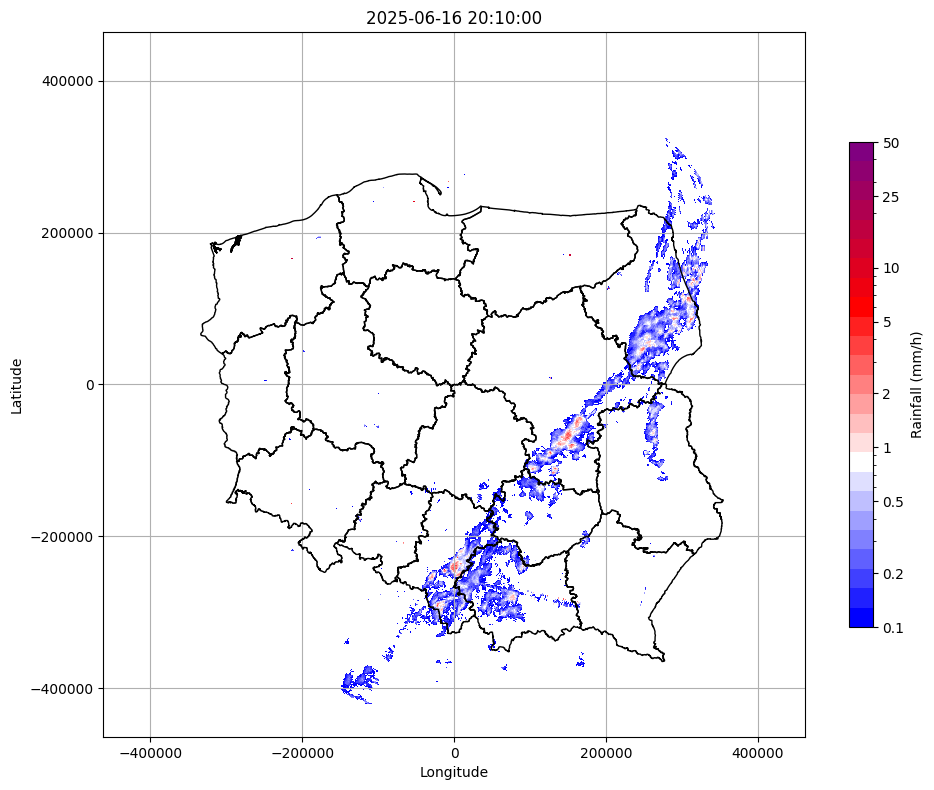

In [163]:
fig, ax = plt.subplots(figsize=(10, 10))


shp_path = os.path.join(DATA_DIR, "gadm41_POL_1.shp")
gdf = gpd.read_file(shp_path)

print("Original CRS:", gdf.crs)  # Optional: verify the original CRS



#TRANSFORM SHP

# Define the source and target CRS
source_crs = gdf.crs  # e.g., EPSG:4326
transformer = Transformer.from_crs(source_crs, proj4string, always_xy=True)

# Function to transform geometries using the transformer
def transform_geometry(geom):
    return transform(transformer.transform, geom)
gdf['geometry'] = gdf['geometry'].apply(transform_geometry)




# Plot the GeoDataFrame on the axes
gdf.boundary.plot(ax=ax, color='black', linewidth=1)

x_lr, y_lr = transformer.transform(lon_lr, lat_lr)  # Lower-right
x_ul, y_ul = transformer.transform(lon_ul, lat_ul)  # Upper-left

# Define extent for plt.imshow: [minx, maxx, miny, maxy] in projected coordinates (meters)
extent = [min(x_ul, x_lr), max(x_ul, x_lr), min(y_lr, y_ul), max(y_lr, y_ul)]

# Create Transformer
transformer = Transformer.from_crs("EPSG:4326", proj4string, always_xy=True)

values_plot = values.copy()
values_plot[values_plot < 0.1] = np.nan  # clip values below 0.1

# --- Custom colormap: blue -> white -> red -> purple ---
colors = [
    (0, 0, 1),    # Blue
    (1, 1, 1),    # White
    (1, 0, 0),    # Red
    (0.5, 0, 0.5) # Purple
]
custom_cmap = LinearSegmentedColormap.from_list('custom_radar', colors, N=25)


im = plt.imshow(
    values_plot,
    cmap=custom_cmap,  # Your custom colormap
    origin='upper',
    norm=LogNorm(vmin=0.1, vmax=50),
    interpolation='nearest',
    extent=extent,  # Use transformed coordinates
    aspect='equal'  # Ensure equal scaling
)

ax.set_aspect('equal')

ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10, 25, 50]
cbar = plt.colorbar(im, ticks=ticks, shrink=0.5)
cbar.ax.set_yticklabels([str(t) for t in ticks])
cbar.set_label('Rainfall (mm/h)')

ax.grid(True)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_title(datetime_str)

# Adjust layout and display
plt.tight_layout()
#plt.show()

output_file = os.path.join(WWW_PATH,"radarimage.png")
plt.savefig(output_file)

remove_all_files_from_dir(TEMP_DIR)